In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Introduction and Problem Definition


Twitter is a  medium of communication and interaction where people send messages also known as tweet, usually about areas that intersts them. Twitter is a good repositiry of data.  The analysis of tweets gives great insights into reactions, needs, and interests of people on a subject matter, organization or people. 
Sentiment analysis is the analysis how people feel about an event or something which is expressed via  data like texts, images, or videos,helping organizations to make decisions on how to better their operations.

This task is about tweets of differnt airlines given target sentiment for each tweet. In this task I will implement the necessary steps to load and prepare the data. Then,comparison on this data will be done, by checking the performances using two machine learning algorithms : A Support Vector Machine and a Neural Network.

# Importing Modules

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from termcolor import cprint
import seaborn as sns   
import wordcloud
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.tokenize import RegexpTokenizer 
import re
from nltk.corpus import stopwords
import unicodedata
import string
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter

#from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
#from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.preprocessing.text import Tokeni

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the data

In [ ]:
tweets =pd.read_csv('/content/drive/MyDrive/Tweets.csv') # loading the tweet data from my drive

In [ ]:
tweets.head()  #checking the first five data in the dataframe

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [ ]:
tweets.info() # checking the basic information contained in the dataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11541 entries, 0 to 11540
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  11541 non-null  object
 1   text               11541 non-null  object
dtypes: object(2)
memory usage: 180.5+ KB


In [ ]:
tweets.isna().sum() # check for missing values

airline_sentiment    0
text                 0
dtype: int64

In [ ]:
tweets['airline_sentiment'].unique() # Checking the unique values of the sentiments

array(['positive', 'negative'], dtype=object)

Bar chart and pie chart to check number and percentage of sentiments

Total number of sentiments of airline tweets :
negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


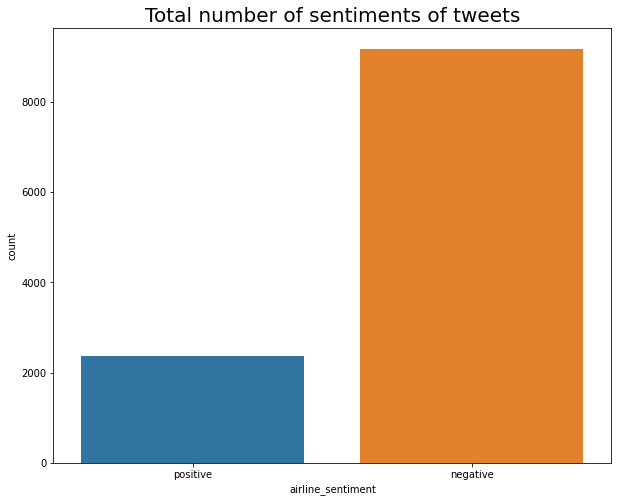

In [ ]:
cprint("Total number of sentiments of airline tweets :",'green')
print(tweets.airline_sentiment.value_counts())
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = 'airline_sentiment', data = tweets)
ax.set_title(label = 'Total number of sentiments of tweets', fontsize = 20)
plt.show()

In [ ]:

fig = px.pie(tweets, names='airline_sentiment', title ='Pie chart of different sentiments of airline tweets')
fig.show()

The negative tweets are more than the positive tweets, the negative tweets are 79.5% while the poisitive tweets are 20.5%

 # Data Preparation / Preprocessing

It is important to perform some preprocessing on our data to make it suitable for learning.A task invoving  Natural Language Processing requires cleaning of the raw text data. This is important so as to help eliminate characters and words which are inconsistent and noisy  thereby giving us data with better features. The preprocessing carried out here includes:
* Assigning 0 and 1 to the airline sentiment column
* checking what people say about flights using Wordcloud
* change the text to lower case so as to have a uniform case

* remove the stop words( in, of, by etc) from text because these words are not helpful and does not support the labels of sentiments data

* remove the punctuations,repeating characters, emails and tags, URL's, numbers because they cause noise in the data. 

* implement tokenization so as to separate the sentence into individual words.

* implement stemming and lemmatization.






In [ ]:
#Assigning 0 and 1 to the positive and negative sentiments so as to encode it
tweets['airline_sentiment'][tweets['airline_sentiment']=='positive']=1
tweets['airline_sentiment'][tweets['airline_sentiment']=='negative']=0

In [ ]:
tweets.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


# checking to see what people say about flights using Wordcloud

In [ ]:
tweets_negative=tweets[tweets['airline_sentiment']==0] # I'll be using the negative sentiment, since it has more representation
words = ' '.join(tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'     
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

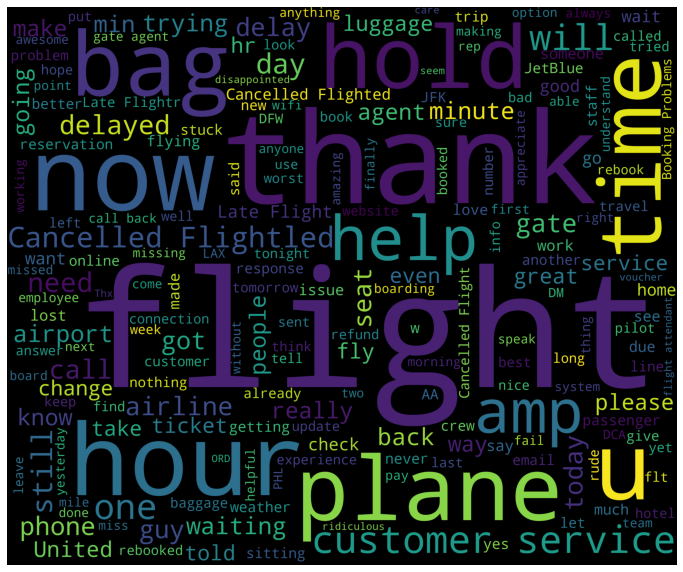

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
tweets_positive=tweets[tweets['airline_sentiment']==1] # I'll like to see the positive sentiments
words = ' '.join(tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'     
                            ])

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

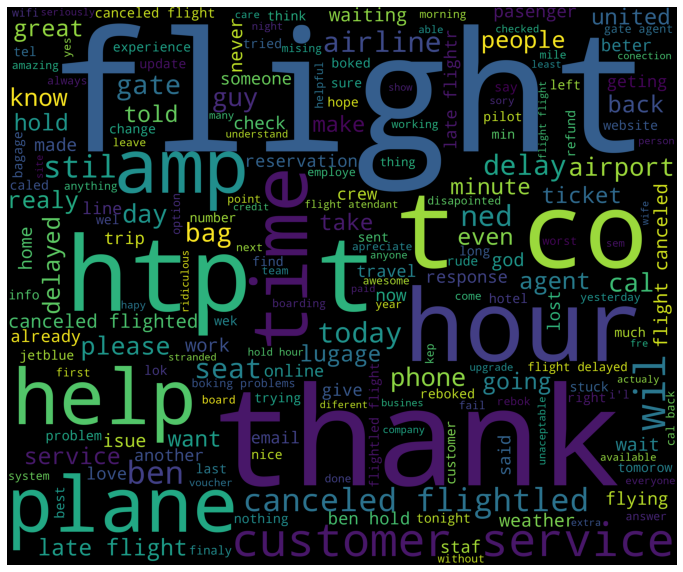

In [ ]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# converting the text to lower case
tweets['text']=tweets['text'].str.lower()
tweets.head()


,airline_sentiment,text
0,1,@virginamerica plus you've added commercials t...
1,0,@virginamerica it's really aggressive to blast...
2,0,@virginamerica and it's a really big bad thing...
3,0,@virginamerica seriously would pay $30 a fligh...
4,1,"@virginamerica yes, nearly every time i fly vx..."


In [ ]:
#removing short words to further give our features a fine look
tweets['text'] =tweets['text'].apply(lambda x: ' '.join([w for w in x.split()  if len(w)>3]))
tweets.head()

,airline_sentiment,text
0,1,@virginamerica plus you've added commercials e...
1,0,@virginamerica it's really aggressive blast ob...
2,0,@virginamerica it's really thing about
3,0,@virginamerica seriously would flight seats th...
4,1,"@virginamerica yes, nearly every time this “ea..."


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

removing stop words

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))  # checking the lists of stopwords

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
tweets['sentiment']=tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [ ]:
def Cleaning_tweets(tweets):
    non_letters_removed = re.sub("[^a-zA-Z]", " ",tweets) 
    words = non_letters_removed.lower().split()                             
    stop_words = set(stopwords.words("english"))                  
    stop_words_removed = [w for w in words if not w in stop_words] 
    return ( " ".join( stop_words_removed ))


In [ ]:
# removing repeating words
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
tweets['text'] = tweets['text'].apply(lambda x: cleaning_repeating_char(x))
tweets['text'].tail()

11536    @americanair flight canceled flightled, leavin...
11537                      @americanair right with delays👌
11538          @americanair thank diferent flight chicago.
11539    @americanair leaving over minutes late flight....
11540    @americanair have money, change flight, don't ...
Name: text, dtype: object

In [ ]:
#removing emails and tags
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [ ]:
tweets['text']= tweets['text'].apply(lambda x: cleaning_email(x))
tweets['text'].tail()

11536      flight canceled flightled, leaving tomorow m...
11537                                   right with delays👌
11538                       thank diferent flight chicago.
11539      leaving over minutes late flight. warnings c...
11540      have money, change flight, don't answer your...
Name: text, dtype: object

In [ ]:
#removing URLs
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)


In [ ]:

tweets['text'] = tweets['text'].apply(lambda x: cleaning_URLs(x))
tweets['text'].tail()

11536      flight canceled flightled, leaving tomorow m...
11537                                   right with delays👌
11538                       thank diferent flight chicago.
11539      leaving over minutes late flight. warnings c...
11540      have money, change flight, don't answer your...
Name: text, dtype: object

In [ ]:
tweets.sample()

,airline_sentiment,text,sentiment
230,0,trying check-in.but loks like your site down?,1


 tokenizing the text

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
tweets['text'] = tweets['text'].apply(tokenizer.tokenize)

In [ ]:
tweets['text'].head()

0    [plus, you, ve, aded, comercials, experience, ...
1    [it, s, realy, agresive, blast, obnoxious, ent...
2                         [it, s, realy, thing, about]
3    [seriously, would, flight, seats, that, didn, ...
4    [yes, nearly, every, time, this, ear, worm, wo...
Name: text, dtype: object

In [ ]:
# applying stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

tweets['text']=tweets['text'].apply(lambda x: stemming_on_text(x))

In [ ]:
tweets.head()
 

,airline_sentiment,text,sentiment
0,1,"[plus, you, ve, aded, comercials, experience, ...",1
1,0,"[it, s, realy, agresive, blast, obnoxious, ent...",1
2,0,"[it, s, realy, thing, about]",1
3,0,"[seriously, would, flight, seats, that, didn, ...",1
4,1,"[yes, nearly, every, time, this, ear, worm, wo...",1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(tweets['text'])

In [ ]:
tfidf.shape

(11541, 1000)


# Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train,test = train_test_split(tweets,test_size=0.2,random_state=42)

In [ ]:
train_data = train.cleaned_tweet.values
test_data = test.cleaned_tweet.values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectorizer, tweets['airline_sentiment'], random_state=42)

#Training Machine Learning *Classifiers*


In [ ]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

# Evaluation of Machine Learning Classifiers

# References

* nltk process: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=twRJodduiumC 
*  Air Line Tweet Sentiment: https://www.kaggle.com/code/loaiabdalslam/air-line-tweet-sentiment-lstm-glove
* Twitter US airlines sentiment analysis: https://www.kaggle.com/code/muhizatar/twitter-us-airlines-sentiment-analysis
* Classifier comparison: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
*
*